# Summary

Have a Genome with heritable recombination




In [217]:
## for local developement
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [726]:
import quickgsim as gsim

## Try to run a large experiment

In [734]:
## Create two chromosomes, use the same instructions for all scenarios
instructions = {1:[10000,194_000_000,4.91],2:[7000,120_000_000,3.12]}

In [735]:
# Set up the genome 
genome = gsim.equidistant_genome(instructions,rs=gsim.randomise(seed=42))

# Add two traits
recomb = gsim.genomicTrait('recomb',0.05,0.2,genome)
recomb.assign_snps_QTLs(genome,250)
recomb.generateQTL_effects(genome)

bwt = gsim.genomicTrait('bwt',90,150,genome,mu=220)
bwt.assign_snps_QTLs(genome,2500)
bwt.generateQTL_effects(genome)


added 10000 variants in chromosome 1 [len in bp:194000000/morgans:4.91] equally spaced every 19401 bp, ie every 0.05 centiMorgans
added 7000 variants in chromosome 2 [len in bp:120000000/morgans:3.12] equally spaced every 17145 bp, ie every 0.04 centiMorgans


In [736]:
## Get the base population
n_sires,n_dams = 100,1000
base_sires = gsim.generate_random_animals(n_sires,1,genome,tags=range(n_sires))
base_dams = gsim.generate_random_animals(n_dams,2,genome,tags=range(1000,1000+n_dams))
founders = base_sires+base_dams

## adjust Va
recomb.adjust_effects_va(founders,genome)
bwt.adjust_effects_va(founders,genome)

## phenotype the founders
for a in founders:
    a.get_phenotype(recomb,genome,fixed_effect=0)
    a.get_phenotype(bwt,genome,fixed_effect=0)


TRAIT recomb -> var_before:552.306,var_after:0.050,target:0.05 [means:32.13 -> 0.00]
TRAIT bwt -> var_before:9096.159,var_after:90.069,target:90 [means:155.93 -> 0.01]


In [745]:
def monitor_bv(trait,ans):
    bv = np.zeros(len(ans))
    gens = []
    for i,an in enumerate(ans):
        gens.append(an.genotype.as_snps()[0])
        for chrom in trait.qtls:
            bv[i] += sum(trait.bv_per_chrom(gens[-1],genome,chrom))
    print(trait.name,trait.get_Va_fromBVs(bv))


def one_gen(sires,dams,genome,gen=1,phenFile_obj=None,rs=gsim.RAN_GEN,s_to_d_ratio=10,male_fert=0.9,female_fert=0.95):
    idx_select = lambda arr,idx : [arr[i] for i in idx]
    min_mates = 5 ##minimum number of female mates
    maxFS = 10    ##maximum number of FS
    
    gen = gen*100_000 ##this could be an issue if more than 100_000 kids per generation
    
    active_sires = rs.choice(len(sires),int(len(sires)*male_fert),replace=False)
    active_dams = rs.choice(len(dams),int(len(sires)*female_fert),replace=False)
    
    ## generate progeny
    boys,girls = [],[]
    n_kids = 1
    for s_idx in active_sires:
        for d_idx in rs.choice(active_dams,rs.integers(min_mates,s_to_d_ratio),replace=False):
            for k in range(rs.integers(1,maxFS)):
                sex = rs.integers(1,3)
                kid_tag = gen+n_kids
                kid = gsim.mate(sires[s_idx],dams[d_idx],kid_tag,genome,kid_sex=sex,mod_len_genomes={'paternal':sires[s_idx].phens['recomb'],'maternal':dams[d_idx].phens['recomb']})    
                n_kids +=1
                ## phenotype the new kid
                pc,mc = kid.get_Ncrossovers('paternal'),kid.get_Ncrossovers('maternal')
                kid.get_phenotype(recomb,genome,fixed_effect=0)
                kid.get_phenotype(bwt,genome,fixed_effect=0)

                if sex == 1:
                    boys.append(kid)
                else:
                    girls.append(kid)
    print(f"In total {n_kids} progeny were generated, {len(boys)} were male and {len(girls)} female")
    
    ## select
    new_sires = idx_select(boys,rs.choice(len(boys),len(sires),replace=False))
    new_dams  = idx_select(girls,rs.choice(len(girls),len(dams),replace=False))
    monitor_bv(recomb,new_sires+new_dams)
    monitor_bv(bwt,new_sires+new_dams)
    return new_sires,new_dams   
        
    

    

In [748]:
s,d = base_sires,base_dams
for gen in range(1,20):
    print(f">> GEN: {gen}")
    s,d = one_gen(s,d,genome,gen=gen)
    print()
    

>> GEN: 1
In total 3128 progeny were generated, 1556 were male and 1571 female
recomb (-0.0455987268787913, 0.050881010380573244)
bwt (-0.7310260590071028, 92.4694027257656)

>> GEN: 2
In total 3161 progeny were generated, 1582 were male and 1578 female
recomb (-0.03835744263866916, 0.05398945974131734)
bwt (-0.20380380927074893, 93.05097111037308)

>> GEN: 3
In total 3134 progeny were generated, 1512 were male and 1621 female
recomb (-0.023906448893922246, 0.056248597927733304)
bwt (-0.3831770709525835, 93.53791971123309)

>> GEN: 4
In total 3085 progeny were generated, 1546 were male and 1538 female
recomb (-0.04042949611676625, 0.06124301583228173)
bwt (-0.0866791149009007, 91.63142197514559)

>> GEN: 5
In total 3279 progeny were generated, 1635 were male and 1643 female
recomb (-0.0701750089886047, 0.05683435726711988)
bwt (0.4318649916709048, 96.13562234127333)

>> GEN: 6
In total 3141 progeny were generated, 1569 were male and 1571 female
recomb (-0.07633208577188955, 0.056606660

In [752]:
def plot_phens(ans,trait):
    p = np.array([a.phens[trait] for a in ans])
    print(p.mean(),p.var())
    plt.hist(p)

221.8107035647594 211.73504329528544


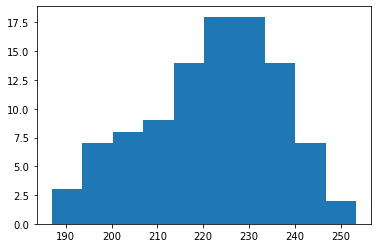

In [755]:
plot_phens(s,'bwt')

In [771]:
## 
def one_gen_select(sires,dams,genome,gen=1,phenFile_obj=None,rs=gsim.RAN_GEN,s_to_d_ratio=10,male_fert=0.9,female_fert=0.95):
    idx_select = lambda arr,idx : [arr[i] for i in idx]
    min_mates = 5 ##minimum number of female mates
    maxFS = 10    ##maximum number of FS
    gen = gen*100_000 ##this could be an issue if more than 100_000 kids per generation
    
    active_sires_idx = rs.choice(len(sires),int(len(sires)*male_fert),replace=False)
    active_dams_idx = rs.choice(len(dams),int(len(sires)*female_fert),replace=False)
    
    ## generate progeny
    boys,girls = [],[]
    n_kids = 1
    for s_idx in active_sires_idx:
        for d_idx in rs.choice(active_dams_idx,rs.integers(min_mates,s_to_d_ratio),replace=False):
            for k in range(rs.integers(1,maxFS)):
                sex = rs.integers(1,3)
                kid_tag = gen+n_kids
                kid = gsim.mate(sires[s_idx],dams[d_idx],kid_tag,genome,kid_sex=sex,mod_len_genomes={'paternal':sires[s_idx].phens['recomb'],'maternal':dams[d_idx].phens['recomb']})    
                n_kids +=1
                ## phenotype the new kid
                pc,mc = kid.get_Ncrossovers('paternal'),kid.get_Ncrossovers('maternal')
                kid.get_phenotype(recomb,genome,fixed_effect=0)
                kid.get_phenotype(bwt,genome,fixed_effect=0)

                if sex == 1:
                    boys.append(kid)
                else:
                    girls.append(kid)
    print(f"In total {n_kids} progeny were generated, {len(boys)} were male and {len(girls)} female")
    
    ## select on BWT
    def select_on_trait(ans,trait,N_sel):
        sel = [idx for idx,bv in sorted([[idx,a.bvs[trait]] for idx,a in enumerate(ans)],key=lambda x:x[1],reverse=True)[:N_sel]]
        return idx_select(ans,sel)

    new_sires = select_on_trait(boys,'bwt',len(sires))
    new_dams  = select_on_trait(girls,'bwt',len(dams))
    monitor_bv(recomb,new_sires+new_dams)
    monitor_bv(bwt,new_sires+new_dams)
    return new_sires,new_dams  


In [781]:
s1,d1 = one_gen_select(s1,d1,genome,gen=20)

In total 3346 progeny were generated, 1675 were male and 1670 female
recomb (-0.03733927288622159, 0.041159079468445624)
bwt (36.94123722356724, 26.298437638628112)


266.9618614581628 159.2648841349398


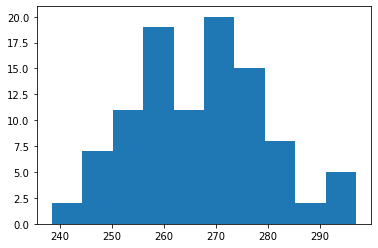

In [782]:
plot_phens(s1,'bwt')

In [780]:
s1?

Type:        list
String form: [Animal(tag:2001930), Animal(tag:2002531), Animal(tag:2002161), Animal(tag:2000494), Animal(tag:2 <...> tag:2002281), Animal(tag:2002066), Animal(tag:2000173), Animal(tag:2000305), Animal(tag:2001696)]
Length:      100
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.


In [763]:
sorted([[a.tag,a.bvs['bwt']] for a in s],key=lambda x:x[1],reverse=True)[:10]

[[1902490, 20.820831156188078],
 [1902639, 19.64234729122114],
 [1902464, 17.55113907213721],
 [1901534, 17.29663694840157],
 [1900363, 15.892858170496677],
 [1902815, 14.883184302939089],
 [1902333, 14.305492967745616],
 [1901219, 12.9006794384441],
 [1900970, 12.049772702036362],
 [1902488, 12.013134934985409]]

In [767]:
sel = [idx for idx,bv in sorted([[idx,a.bvs['bwt']] for idx,a in enumerate(s)],key=lambda x:x[1],reverse=True)[:10]]

In [768]:
idx_select(s,sel)

[Animal(tag:1902490),
 Animal(tag:1902639),
 Animal(tag:1902464),
 Animal(tag:1901534),
 Animal(tag:1900363),
 Animal(tag:1902815),
 Animal(tag:1902333),
 Animal(tag:1901219),
 Animal(tag:1900970),
 Animal(tag:1902488)]

## POC

In [564]:
## Create two chromosomes, use the same instructions for all scenarios
instructions = {1:[2000,1_000_000,2.2],2:[3000,2_000_000,3.1]}

In [646]:
# Set up the genome 
genome = gsim.equidistant_genome(instructions,rs=gsim.randomise(seed=42))

# Add two traits
recomb = gsim.genomicTrait('recomb',0.05,0.2,genome)
recomb.assign_snps_QTLs(genome,180)
recomb.generateQTL_effects(genome)

bwt = gsim.genomicTrait('bwt',90,150,genome,mu=220)
bwt.assign_snps_QTLs(genome,500)
bwt.generateQTL_effects(genome)



added 2000 variants in chromosome 1 [len in bp:1000000/morgans:2.2] equally spaced every 500 bp, ie every 0.11 centiMorgans
added 3000 variants in chromosome 2 [len in bp:2000000/morgans:3.1] equally spaced every 666 bp, ie every 0.1 centiMorgans


In [647]:
## Get the base population
base_sires = gsim.generate_random_animals(80,1,genome,tags=range(80))
base_dams = gsim.generate_random_animals(500,2,genome,tags=range(100,600))
founders = base_sires+base_dams

In [648]:
recomb.adjust_effects_va(founders,genome)
bwt.adjust_effects_va(founders,genome)

TRAIT recomb -> var_before:305.59901456766136,var_after:0.04969281580336569,target:0.05
TRAIT bwt -> var_before:1537.6601427231658,var_after:89.97856918884494,target:90


In [697]:
s,d = base_sires[0],base_dams[0]

In [698]:
s.get_phenotype(recomb,genome,fixed_effect=0)
d.get_phenotype(recomb,genome,fixed_effect=0)
s.get_phenotype(bwt,genome,fixed_effect=0)
d.get_phenotype(bwt,genome,fixed_effect=0)

print(s.phens,s.bvs)

{'recomb': 0.5355892315570852, 'bwt': 219.0674938355628} {'recomb': -0.13496490658943533, 'bwt': -2.417366654522265}


In [699]:
a = gsim.mate(s,d,1001,genome,kid_sex=1,mod_len_genomes={'paternal':s.phens['recomb'],'maternal':d.phens['recomb']})

In [700]:
a.mcr,a.get_Ncrossovers('maternal')

({1: [[1, 0], array([2269, 4757, 6697])],
  2: [[0, 0], array([  52,  978, 1399, 4653, 4777, 5507])]},
 9)

In [701]:
a.get_phenotype(recomb,genome,fixed_effect=0)
a.get_phenotype(bwt,genome,fixed_effect=0)
print(a.phens,a.bvs)

{'recomb': 0.32518389989685004, 'bwt': 224.832233457629} {'recomb': -0.08441731985662457, 'bwt': 3.2668835096198414}


In [649]:
for a in founders:
    a.get_phenotype(recomb,genome,fixed_effect=0)
    a.get_phenotype(bwt,genome,fixed_effect=0)

    

In [545]:
s.phens,s.bvs

({'recomb': 0.3377983762429465, 'bwt': 200.54361172661908},
 {'recomb': -0.15976334987723745, 'bwt': -17.009266781707677})

(array([  3.,  17.,  92., 109., 135., 135.,  61.,  23.,   4.,   1.]),
 array([174.18797839, 184.32728944, 194.46660048, 204.60591153,
        214.74522258, 224.88453363, 235.02384468, 245.16315573,
        255.30246677, 265.44177782, 275.58108887]),
 <BarContainer object of 10 artists>)

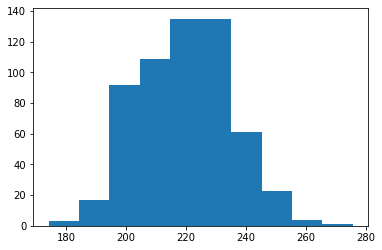

In [650]:
tr = 'bwt'
plt.hist([a.phens[tr] for a in founders])

(array([  4.,  24.,  58.,  79., 131.,  96., 102.,  57.,  23.,   6.]),
 array([-26.49181679, -21.23682111, -15.98182542, -10.72682973,
         -5.47183405,  -0.21683836,   5.03815732,  10.29315301,
         15.54814869,  20.80314438,  26.05814006]),
 <BarContainer object of 10 artists>)

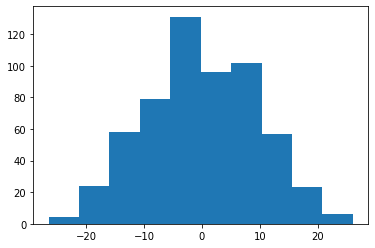

In [651]:
plt.hist([a.bvs[tr] for a in founders])

In [652]:
b,p = np.array([a.bvs[tr] for a in founders]),np.array([a.phens[tr] for a in founders])
b.var(),p.var(),b.var()/p.var(),(p-b).var(),b.mean(),p.mean()

(89.97856918884494,
 229.07159091378753,
 0.3927967183966907,
 154.50960415765175,
 -0.0018545628250670263,
 219.68880646098762)

In [286]:
###
gens = []
for s in base_sires:
    gens.append(s.genotype.as_snps()[0])
for d in base_dams:
    gens.append(d.genotype.as_snps()[0])
    


In [208]:
base_sires[0].get_bv(recomb,genome),base_sires[0].get_bv(bwt,genome)

(1.0044984210574697, 28.19570689011314)

In [209]:
base_sires[0].bvs

{'recomb': 1.0044984210574697, 'bwt': 28.19570689011314}

In [212]:
base_sires[0].get_phenotype(recomb,genome),base_sires[0].get_phenotype(bwt,genome)

(1.5531698820145905, 32.377159514334544)

In [213]:
base_sires[0].phens

{'recomb': 1.5531698820145905, 'bwt': 32.377159514334544}

## Testing

In [100]:
genome = gsim.equidistant_genome(instructions,rs=gsim.randomise(seed=42))

added 20 variants in chromosome 1 [len in bp:1000000/morgans:2.2] equally spaced every 52631 bp, ie every 11.58 centiMorgans
added 30 variants in chromosome 2 [len in bp:2000000/morgans:3.1] equally spaced every 68965 bp, ie every 10.69 centiMorgans


In [101]:
recomb = gsim.genomicTrait('recomb',0.2,0.80,genome,10)

In [102]:
recomb.assign_snps_QTLs(genome,8)

In [64]:
recomb.qtls

{1: [2, 4, 9], 2: [7, 11, 21, 22, 23]}

In [93]:
genome.chroms[1].variants[11]

Variant(chrom=1, pos=578947.3684210526, cm_pos=127.3684210526316, add_effects={})

In [94]:
recomb.generateQTL_effects(genome)

In [67]:
genome.chroms[1].variants[11]

Variant(chrom=1, pos=578947.3684210526, cm_pos=127.3684210526316, add_effects={})

In [291]:
def get_bv(qtls,gens,genome,Va):
    bv = []
    for c in qtls:
        bv.extend(genome.chroms[c].variants[s1].add_effects['recomb']*gens[c][s1] for s1 in qtls[c])
        print(bv)
    bv = np.array(bv)
    v  = bv.var()

    coef = np.sqrt(Va/v)
    bv1 = []
    for c in qtls:
        for s in qtls[c]:
            genome.chroms[c].variants[s].add_effects['recomb'] *= coef            
            bv1.append(genome.chroms[c].variants[s].add_effects['recomb']*gens[c][s])
        print(bv1)
        
    bv2 = bv*coef
    print(bv2)
    print(v,coef,np.array(bv1).var(),bv2.var())
    
    
    

In [95]:
gens = {}
for c in genome.chroms:
    gens[c] = gsim.RAN_GEN.integers(0,3,size=genome.chroms[c].nvars)
print(gens)

{1: array([1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0]), 2: array([0, 0, 1, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 1,
       0, 0, 1, 1, 0, 0, 1, 1])}


In [96]:
recomb.adjust_effects_va(gens,genome)

0.003035130499118092 0.20000000000000004 0.2


In [97]:
print(genome.chroms[1].variants[11])
print(gens[1][recomb.qtls[1]])
recomb.bv_per_chrom(gens,genome,1)

Variant(chrom=1, pos=578947.3684210526, cm_pos=127.3684210526316, add_effects={})
[0 2 0]


array([-0.        , -1.35120542, -0.        ])

In [413]:
Va = 10
get_bv(recomb.qtls,gens,genome,Va)

[0.0049865606565159355, -0.08563877572641655, 1.341701845788911]
[0.0049865606565159355, -0.08563877572641655, 1.341701845788911, 1.060813083544787e-05, 0.033861452562343984, -3.193780299317197e-05, 0.0, -0.002829951841237703]
[0.0352603085502046, -0.6055575904866304, 9.487264734878464]
[0.0352603085502046, -0.6055575904866304, 9.487264734878464, 7.501081249459304e-05, 0.23943662727660026, -0.00022583437072671913, 0.0, -0.020010781373705357]
[ 3.52603086e-02 -6.05557590e-01  9.48726473e+00  7.50108125e-05
  2.39436627e-01 -2.25834371e-04  0.00000000e+00 -2.00107814e-02]
0.20000000000000004 7.071067811865475 10.000000000000002 10.000000000000002


In [20]:
genome.chroms[1].variants[11]

Variant(chrom=1, pos=578947.3684210526, cm_pos=127.3684210526316, add_effects={'recomb': 26.751541618165056})

In [256]:
get_bv(recomb.qtls,gens,genome,Va)

10.0 1.0 4.773749820403482 10.0


In [418]:
c = 1
qidx = recomb.qtls[c]
base_sires[0].genotype.as_snps()[0][c][qidx ]  

array([1, 1, 1])

In [420]:
[v.get_effect('recomb') for v in genome.chroms[1].get_variants_attrs(qidx)]

[array(0.00498656), array(-0.04281939), array(0.67085092)]

In [95]:
## Need to define a trait for recombination
recomb = gsim.pedTrait('recomb',5,10,genome,10)

TypeError: loop of ufunc does not support argument 0 of type Genome which has no callable sqrt method

In [116]:

gens = {}
for c in genome.chroms:
    gens[c] = gsim.RAN_GEN.integers(0,3,size=genome.chroms[c].nvars)
print(gens)
recomb.adjust_effects_va(gens,genome)

added 20 variants in chromosome 1 [len in bp:1000000/morgans:2.2] equally spaced every 52631 bp, ie every 11.58 centiMorgans
added 30 variants in chromosome 2 [len in bp:2000000/morgans:3.1] equally spaced every 68965 bp, ie every 10.69 centiMorgans
{1: array([1, 0, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 0, 1, 1, 2]), 2: array([1, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0,
       2, 2, 2, 1, 0, 2, 2, 0])}
1.3571793286740796 0.2 0.2


In [117]:
base_sires = gsim.generate_random_animals(5,1,genome,tags=range(5))
base_dams = gsim.generate_random_animals(10,2,genome,tags=range(10,20))

In [118]:
base_sires[0].get_bv(recomb,genome)

[-0.00609771  0.0850939  -0.01067089]
[-4.01076675e-04  3.95561176e-01 -1.39356940e+00 -6.43185048e-06
 -0.00000000e+00]


-0.9300904295971318

In [31]:
for i in range(5):
    bv = recomb.draw_bv()
    phen = recomb.get_phen(bv)
    base_sires[i].add_bv('recomb',bv)
    base_sires[i].add_pheno('recomb',phen)

In [35]:
for i in range(5):
    print(base_sires[i].get_phenotype('recomb'))

-0.3114359231176276
-0.6063677111897279
0.04575693492272444
0.9148249469510936
-0.38152816252099664
